In [1]:
import chipwhisperer as cw
scope = cw.scope()

(ChipWhisperer NAEUSB WARNING|File naeusb.py:738) Your firmware (1.4) is outdated - latest is 1.5 See https://chipwhisperer.readthedocs.io/en/latest/firmware.html for more information


In [3]:
from chipwhisperer.hardware.naeusb.programmer_targetfpga import CW312T_XC7A35T
fpga = CW312T_XC7A35T(scope)
scope.io.hs2 = None
fpga.program('top_cw312a35.bit', sck_speed=10e6)
scope.default_setup()
scope.clock.adc_mul = 1
scope.clock.clkgen_freq = 100e6
scope.trigger.triggers = "tio4"
scope.io.tio1 = "serial_rx"
scope.io.tio2 = "serial_tx"
scope.io.hs2 = "clkgen"

## AES Figure

In [7]:
target.baud = 115200
scope.adc.samples = 100000

In [50]:
from tqdm import tnrange
ktp = cw.ktp.Basic()
key, text = ktp.next()
trace = cw.capture_trace(scope, target, text, key)

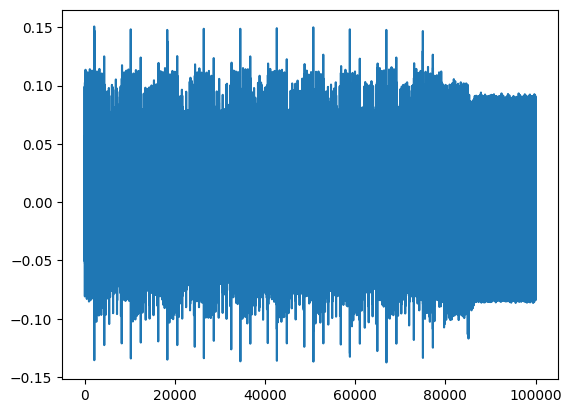

In [51]:
import matplotlib.pylab as plt
plt.plot(trace.wave)

In [53]:
import numpy as np
np.save("aes_trace.npy", trace.wave)

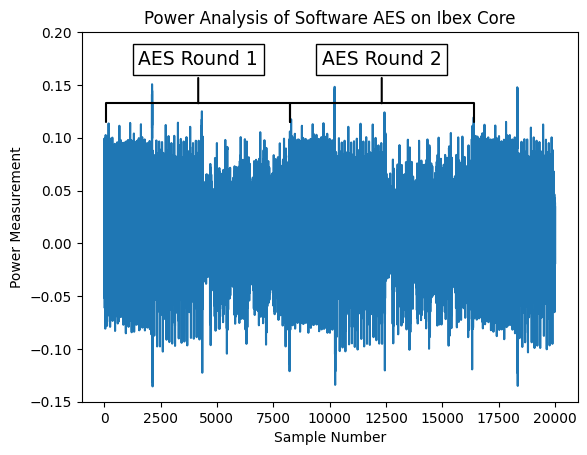

In [103]:
ax = plt.axes()
ax.plot(trace.wave[0:20000])
fs = 9.0
plt.xlabel('Sample Number')
plt.ylabel('Power Measurement')

# Here is the label and arrow code of interest
ax.annotate('AES Round 1', xy=(0.235, 0.80), xytext=(0.235, 0.90), xycoords='axes fraction', 
            fontsize=fs*1.5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=4.9, lengthB=1', lw=1.5))

ax.annotate('AES Round 2', xy=(0.235+0.37, 0.80), xytext=(0.235+0.37, 0.90), xycoords='axes fraction', 
            fontsize=fs*1.5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=4.9, lengthB=1', lw=1.5))


plt.ylim([-0.15, 0.2])

plt.title('Power Analysis of Software AES on Ibex Core')

plt.savefig("AESTrace.png", format="png", dpi=600)
plt.savefig("AESTrace.svg", format="svg")

## Hamming Weight Figure

In [105]:
from tqdm import tnrange
import numpy as np
import time

ktp = cw.ktp.Basic()
trace_array = []
textin_array = []

key, text = ktp.next()

target.set_key(key)

N = 1000
for i in tnrange(N, desc='Capturing traces'):
    scope.arm()
    
    target.simpleserial_write('p', text)
    
    ret = scope.capture()
    if ret:
        print("Target timed out!")
        continue
    
    response = target.simpleserial_read('r', 16)
    
    trace_array.append(scope.get_last_trace())
    textin_array.append(text)
    
    key, text = ktp.next() 

C:\Users\colin\AppData\Local\Temp\ipykernel_11728\2553989440.py:14: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(N, desc='Capturing traces'):


Capturing traces:   0%|          | 0/1000 [00:00<?, ?it/s]

In [107]:
HW = [bin(n).count("1") for n in range(0, 256)]

In [110]:
sbox = [
    # 0    1    2    3    4    5    6    7    8    9    a    b    c    d    e    f 
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76, # 0
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0, # 1
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15, # 2
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75, # 3
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84, # 4
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf, # 5
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8, # 6
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2, # 7
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73, # 8
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb, # 9
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79, # a
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08, # b
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a, # c
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e, # d
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf, # e
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16  # f
]

def aes_internal(inputdata, key):
    return sbox[inputdata ^ key]

In [175]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.palettes import brewer

plot_start = 0
plot_end = 20000
xrange = range(len(trace_array[0]))[plot_start:plot_end]
bnum = 4
color_mapper = brewer['PRGn'][9]

In [176]:
output_notebook()
p = figure()

hw_groups = [[], [], [], [], [], [], [], [], []]
for tnum in range(len(trace_array)):
    hw_of_byte = HW[aes_internal(textin_array[tnum][bnum], key[bnum])]
    hw_groups[hw_of_byte].append(trace_array[tnum])
hw_averages = np.array([np.average(hw_groups[hw], axis=0) for hw in range(9)])
avg_trace = np.average(hw_averages, axis=0)

xrange = range(len(trace_array[0]))[plot_start:plot_end]
color_mapper = brewer['PRGn'][9]
for hw in range(9):  
    p.line(xrange, (hw_averages[hw]-avg_trace)[plot_start:plot_end], line_color=color_mapper[hw])
    
show(p)

Loading BokehJS ...

In [179]:
#sbox_loc = np.argmax(abs(hw_averages[0][0:4000]-avg_trace[0:4000]))
#print(sbox_loc)

sbox_loc = 2388

2379


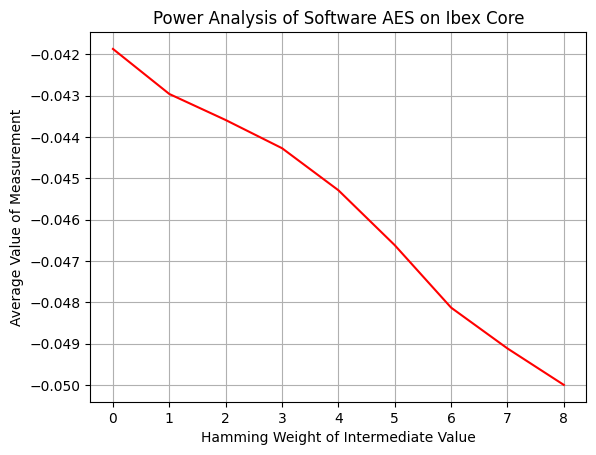

In [183]:
ax = plt.axes()
ax.plot(range(0, 9), hw_averages[:,sbox_loc], 'r')

plt.xlabel('Hamming Weight of Intermediate Value')
plt.ylabel('Average Value of Measurement')

plt.title('Power Analysis of Software AES on Ibex Core')
plt.grid(True)

plt.savefig("HWFigure.png", format="png", dpi=600)
plt.savefig("HWFigure.svg", format="svg")

## AES Attack

In [172]:
scope.adc.samples = 7000

In [173]:
from tqdm import tnrange
ktp = cw.ktp.Basic()

#Set your project name here
project = cw.create_project("riscv_aes", overwrite = True)

#Set your number of traces here
num_traces = 500

for i in tnrange(num_traces, desc='Capturing traces'):
    key, text = ktp.next()  # manual creation of a key, text pair can be substituted here
    trace = cw.capture_trace(scope, target, text, key)
    if trace is None:
        continue
    project.traces.append(trace)
        
project.save()

C:\Users\colin\AppData\Local\Temp\ipykernel_11728\1030190234.py:10: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(num_traces, desc='Capturing traces'):


Capturing traces:   0%|          | 0/500 [00:00<?, ?it/s]

In [174]:
import chipwhisperer.analyzer as cwa
#pick right leakage model for your attack
leak_model = cwa.leakage_models.sbox_output
attack = cwa.cpa(project, leak_model)
results = attack.run(cwa.get_jupyter_callback(attack))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
PGE=,21,53,237,20,0,165,91,152,119,49,120,69,100,182,201,92
0,6C0.793,EC0.698,C60.670,7F0.733,280.762,7D0.688,080.738,3D0.645,EB0.754,870.750,660.700,F00.613,730.498,8B0.599,360.596,CF0.681
1,4F0.319,8A0.285,2C0.332,EC0.297,170.304,120.299,FF0.289,9A0.276,040.318,940.297,110.289,CF0.289,7C0.265,250.310,610.300,980.289
2,7F0.290,DB0.271,720.314,980.289,CC0.272,AB0.297,580.283,AF0.271,BF0.307,370.282,540.287,420.270,F90.256,B40.299,420.262,590.279
3,A50.284,1E0.259,AF0.296,2D0.289,440.270,D00.267,4F0.263,850.264,9B0.292,B80.273,B40.278,FF0.264,830.254,2C0.278,CB0.254,4B0.268
4,000.271,420.254,330.280,850.266,740.268,CD0.264,5F0.252,CA0.256,1E0.290,4D0.272,8D0.267,C50.263,8D0.253,EE0.273,D20.250,EC0.261
